# Validation Against MATLAB Spectral Clustering Experiments

This notebook recreates the experiments from `~/lawrennd/spectral/matlab/` to validate the Python `CommunityDetector` implementation against the original MATLAB reference code (Sanguinetti, Lawrence & Laidler, 2005).

## MATLAB vs Python Implementation Notes

**Key difference**: The MATLAB demos use **Gaussian affinity matrices** computed from Euclidean distances:
```matlab
A(i,j) = exp(-||x(i,:)-x(j,:)||^2/sigma)
L = D^{-1/2} A D^{-1/2}
```

Our `CommunityDetector` uses **bipartite transition matrices** for country-product networks:
```python
T = D_c^{-1} M D_p^{-1} M^T
```

To properly validate, we need to adapt `CommunityDetector` to accept pre-computed affinity/transition matrices, or create a wrapper that computes Gaussian affinities.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.linalg import eigh
from PIL import Image
import sys
sys.path.insert(0, '..')

from fitkit.community.detection import CommunityDetector

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## Helper: Gaussian Affinity Matrix Construction

To match MATLAB experiments, we need to construct affinity matrices from point clouds.

In [15]:
def compute_gaussian_affinity(X, sigma2):
    """Compute Gaussian affinity matrix as in MATLAB SpectralCluster.
    
    A(i,j) = exp(-||x(i,:)-x(j,:)||^2/sigma2)
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Data points.
    sigma2 : float
        Variance parameter for Gaussian kernel.
    
    Returns
    -------
    A : ndarray of shape (n_samples, n_samples)
        Affinity matrix.
    """
    from scipy.spatial.distance import cdist
    dist_sq = cdist(X, X, metric='sqeuclidean')
    A = np.exp(-dist_sq / sigma2)
    return A

def affinity_to_normalized_laplacian(A):
    """Convert affinity matrix to normalized Laplacian.
    
    L = D^{-1/2} A D^{-1/2}
    
    Parameters
    ----------
    A : ndarray of shape (n, n)
        Affinity matrix.
    
    Returns
    -------
    L : ndarray of shape (n, n)
        Normalized Laplacian.
    """
    D = A.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-10))
    L = D_inv_sqrt @ A @ D_inv_sqrt
    return L

## Experiment 1: Three Circles (demoCircles.m)

Generate three concentric circles with noise and cluster them.

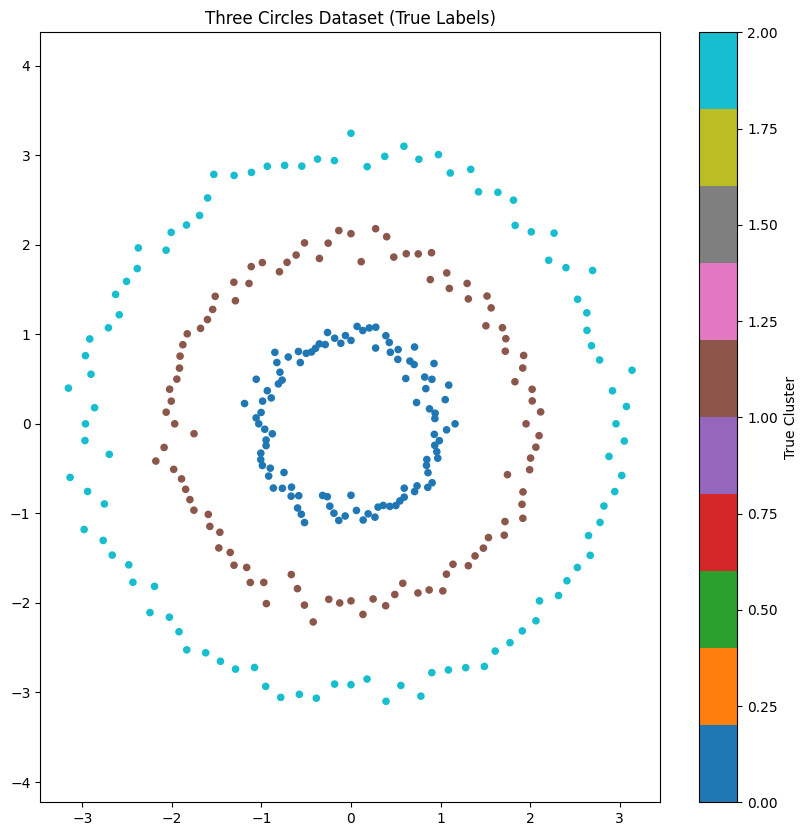

Dataset shape: (300, 2)
Expected clusters: 3


In [16]:
# Generate three circles data (matching MATLAB)
np.random.seed(1)
npts = 100
theta = np.linspace(0, 2*np.pi, npts, endpoint=False)
radius_noise = np.random.randn(npts)

r1 = 1.0 + 0.1 * radius_noise
r2 = 2.0 + 0.1 * np.random.randn(npts)
r3 = 3.0 + 0.1 * np.random.randn(npts)

x_circles = np.vstack([
    np.column_stack([r1 * np.cos(theta), r1 * np.sin(theta)]),
    np.column_stack([r2 * np.cos(theta), r2 * np.sin(theta)]),
    np.column_stack([r3 * np.cos(theta), r3 * np.sin(theta)])
])

true_labels = np.repeat([0, 1, 2], npts)

# Visualize
plt.figure(figsize=(10, 10))
plt.scatter(x_circles[:, 0], x_circles[:, 1], c=true_labels, cmap='tab10', s=20)
plt.title('Three Circles Dataset (True Labels)')
plt.axis('equal')
plt.colorbar(label='True Cluster')
plt.show()

print(f"Dataset shape: {x_circles.shape}")
print(f"Expected clusters: 3")

In [17]:
# Compute affinity matrix (sigma2 = 0.05 from MATLAB)
sigma2 = 0.05
A_circles = compute_gaussian_affinity(x_circles, sigma2)
L_circles = affinity_to_normalized_laplacian(A_circles)

print(f"Affinity matrix shape: {A_circles.shape}")
print(f"Affinity matrix sparsity: {(A_circles < 0.01).sum() / A_circles.size * 100:.1f}% near-zero")

Affinity matrix shape: (300, 300)
Affinity matrix sparsity: 97.0% near-zero


Top 10 eigenvalues:
[1.         0.99999444 0.9999578  0.99916809 0.99879713 0.99762373
 0.99715529 0.99660297 0.99507762 0.99148986]


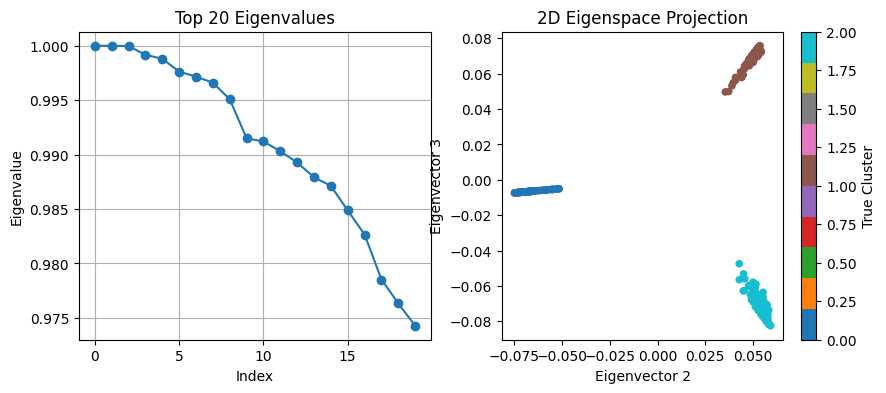

In [18]:
# Extract top eigenvectors
eigenvalues, eigenvectors = eigh(L_circles)
idx = np.argsort(np.abs(eigenvalues))[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Top 10 eigenvalues:")
print(eigenvalues[:10])

# Plot eigenvalue spectrum
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(eigenvalues[:20], 'o-')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Top 20 Eigenvalues')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=true_labels, cmap='tab10', s=20)
plt.xlabel('Eigenvector 2')
plt.ylabel('Eigenvector 3')
plt.title('2D Eigenspace Projection')
plt.colorbar(label='True Cluster')
plt.show()

### Run Elongated K-Means on Eigenvectors

Since `CommunityDetector` expects a bipartite matrix, we'll manually run the elongated k-means algorithm on the eigenvectors.

In [19]:
# Manual implementation following MATLAB algorithm
# Start with q=2 eigenvectors, iterate until origin is empty

def run_spectral_cluster_manual(eigenvectors, eigenvalues, max_dim=10, lambda_elongation=0.2):
    """Manual implementation of SpectralCluster algorithm."""
    from fitkit.community.detection import CommunityDetector
    
    detector = CommunityDetector(max_communities=max_dim, lambda_elongation=lambda_elongation, random_state=42)
    
    # Start with Dim=2
    for dim in range(2, max_dim + 1):
        # Extract first dim eigenvectors (MATLAB: Y(:,(1:Dim)) includes ALL from column 1)
        PcEig = eigenvectors[:, 0:dim]
        
        # Run elongated k-means with origin detector
        k = dim - 1  # Number of non-origin clusters
        labels, origin_empty, centers = detector._elongated_kmeans_with_origin(PcEig, k)
        
        print(f"Dim={dim}, k={k}: origin_empty={origin_empty}, origin_size={(labels==k).sum()}")
        
        if origin_empty:
            # Found correct number of clusters
            final_labels = detector._elongated_kmeans(PcEig, k, initial_centers=centers[:k])
            return final_labels, dim, PcEig, centers[:k]
    
    # If we reach here, use max_dim
    PcEig = eigenvectors[:, 0:max_dim]
    final_labels = detector._elongated_kmeans(PcEig, max_dim - 1)
    return final_labels, max_dim, PcEig, None

# Run the algorithm
labels_circles, n_clusters, PcEig_circles, centers_circles = run_spectral_cluster_manual(
    eigenvectors, eigenvalues, max_dim=10
)

print(f"\nDetected {n_clusters} clusters")
print(f"Unique labels: {np.unique(labels_circles)}")

Dim=2, k=1: origin_empty=False, origin_size=200
Dim=3, k=2: origin_empty=False, origin_size=100
Dim=4, k=3: origin_empty=False, origin_size=58
Dim=5, k=4: origin_empty=False, origin_size=49
Dim=6, k=5: origin_empty=False, origin_size=49
Dim=7, k=6: origin_empty=False, origin_size=90
Dim=8, k=7: origin_empty=False, origin_size=82
Dim=9, k=8: origin_empty=False, origin_size=100
Dim=10, k=9: origin_empty=False, origin_size=85

Detected 10 clusters
Unique labels: [0 1 2 3 4 5 6 7 8]


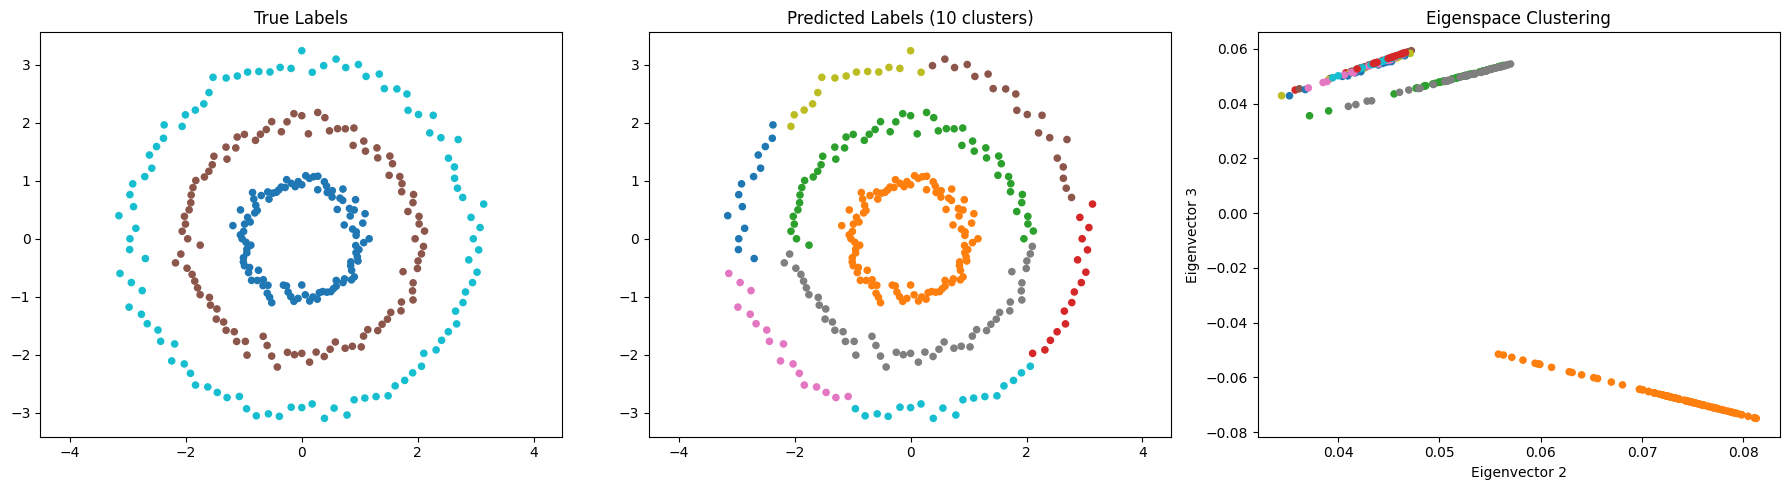

True cluster 0: {1: 100}
True cluster 1: {2: 52, 6: 48}
True cluster 2: {3: 16, 4: 20, 7: 15, 0: 14, 5: 17, 8: 18}


In [20]:
# Visualize clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data with true labels
axes[0].scatter(x_circles[:, 0], x_circles[:, 1], c=true_labels, cmap='tab10', s=20)
axes[0].set_title('True Labels')
axes[0].axis('equal')

# Original data with predicted labels
axes[1].scatter(x_circles[:, 0], x_circles[:, 1], c=labels_circles, cmap='tab10', s=20)
axes[1].set_title(f'Predicted Labels ({n_clusters} clusters)')
axes[1].axis('equal')

# Eigenspace with predicted labels
axes[2].scatter(PcEig_circles[:, 0], PcEig_circles[:, 1], c=labels_circles, cmap='tab10', s=20)
if centers_circles is not None:
    axes[2].scatter(centers_circles[:, 0], centers_circles[:, 1], 
                   c='black', marker='D', s=100, edgecolors='white', linewidths=2)
axes[2].set_xlabel('Eigenvector 2')
axes[2].set_ylabel('Eigenvector 3')
axes[2].set_title('Eigenspace Clustering')

plt.tight_layout()
plt.show()

# Compute clustering quality
from collections import Counter
for true_label in range(3):
    mask = true_labels == true_label
    pred_in_cluster = labels_circles[mask]
    counts = Counter(pred_in_cluster)
    print(f"True cluster {true_label}: {dict(counts)}")

## Experiment 2: Shapes Image Segmentation (demoShapes.m)

Load shapes.bmp and segment based on spatial coordinates + intensity.

In [ ]:
# Load shapes image
img_path = '~/lawrennd/spectral/matlab/shapes.bmp'
img = Image.open(img_path.replace('~', '/Users/neil'))
img_array = np.array(img)

# If RGB, convert to grayscale
if len(img_array.shape) == 3:
    img_gray = img_array.sum(axis=2)
else:
    img_gray = img_array

# Normalize
img_norm = img_gray / img_gray.max()

print(f"Image shape: {img_norm.shape}")
plt.figure(figsize=(8, 8))
plt.imshow(img_norm, cmap='gray')
plt.title('Shapes Image')
plt.colorbar()
plt.show()

In [ ]:
# Extract coordinates and intensities (matching MATLAB)
numrows, numcols = img_norm.shape
n = numrows * numcols

# Flatten image
f = img_norm.ravel()

# Create coordinate matrices
x1 = np.tile(np.arange(numrows), numcols)
x2 = np.repeat(np.arange(numcols), numrows)

# Combine coordinates and intensity (weight intensity same as spatial)
x_shapes = np.column_stack([x1, x2, f * (numrows + numcols)])

print(f"Data matrix shape: {x_shapes.shape}")
print(f"Coordinate range: x1=[{x1.min()}, {x1.max()}], x2=[{x2.min()}, {x2.max()}]")
print(f"Intensity range: [{f.min():.3f}, {f.max():.3f}]")

In [ ]:
# Compute affinity matrix (sigma2 = 1 from MATLAB)
# WARNING: This will be slow for large images!
print("Computing affinity matrix... (this may take a while)")

sigma2_shapes = 1.0
# For speed, subsample if image is large
if n > 1000:
    print(f"Image has {n} pixels, subsampling to 1000 for speed...")
    subsample_idx = np.random.choice(n, size=1000, replace=False)
    x_shapes_sub = x_shapes[subsample_idx]
    img_norm_sub = img_norm.ravel()[subsample_idx]
else:
    x_shapes_sub = x_shapes
    img_norm_sub = img_norm.ravel()

A_shapes = compute_gaussian_affinity(x_shapes_sub, sigma2_shapes)
L_shapes = affinity_to_normalized_laplacian(A_shapes)

print(f"Affinity matrix shape: {A_shapes.shape}")

In [ ]:
# Extract eigenvectors
print("Computing eigenvectors...")
eigenvalues_shapes, eigenvectors_shapes = eigh(L_shapes)
idx = np.argsort(np.abs(eigenvalues_shapes))[::-1]
eigenvalues_shapes = eigenvalues_shapes[idx]
eigenvectors_shapes = eigenvectors_shapes[:, idx]

print("Top 10 eigenvalues:")
print(eigenvalues_shapes[:10])

plt.figure(figsize=(10, 4))
plt.plot(eigenvalues_shapes[:20], 'o-')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Spectrum (Shapes)')
plt.grid(True)
plt.show()

In [ ]:
# Run clustering
print("Running spectral clustering...")
labels_shapes, n_clusters_shapes, PcEig_shapes, centers_shapes = run_spectral_cluster_manual(
    eigenvectors_shapes, eigenvalues_shapes, max_dim=10
)

print(f"\nDetected {n_clusters_shapes} clusters")
print(f"Cluster sizes: {np.bincount(labels_shapes)}")

In [ ]:
# Visualize segmentation
if len(x_shapes_sub) < n:
    print("Note: Showing results on subsampled data")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Original image
axes[0].imshow(img_norm, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Clustered points (spatial view)
axes[1].scatter(x_shapes_sub[:, 1], x_shapes_sub[:, 0], c=labels_shapes, cmap='tab10', s=10)
axes[1].set_title(f'Segmentation ({n_clusters_shapes} clusters)')
axes[1].invert_yaxis()
axes[1].axis('equal')

plt.tight_layout()
plt.show()

## Experiment 3: Bipartite Network (Economic Fitness)

Test on synthetic bipartite networks to validate the transition matrix approach.

In [ ]:
# Generate 2-block modular bipartite network
np.random.seed(42)
n_countries = 20
n_products = 16

M = np.zeros((n_countries, n_products))

# Block 1: countries 0-9 export products 0-7
M[0:10, 0:8] = 1

# Block 2: countries 10-19 export products 8-15
M[10:20, 8:16] = 1

# Add some cross-block connections for connectivity
for i in range(10):
    products = np.random.choice(range(8, 16), size=1, replace=False)
    M[i, products] = 1
    
for i in range(10, 20):
    products = np.random.choice(range(0, 8), size=1, replace=False)
    M[i, products] = 1

M_sparse = sparse.csr_matrix(M)
true_labels_bipartite = np.array([0]*10 + [1]*10)

# Visualize
plt.figure(figsize=(10, 6))
plt.imshow(M, cmap='binary', aspect='auto', interpolation='none')
plt.xlabel('Products')
plt.ylabel('Countries')
plt.title('Modular Bipartite Network')
plt.colorbar(label='Export')
plt.show()

print(f"Network shape: {M.shape}")
print(f"Density: {M.sum() / M.size * 100:.1f}%")

In [ ]:
# Use CommunityDetector directly (uses bipartite transition matrix)
detector_bipartite = CommunityDetector(max_communities=10, random_state=42)
labels_bipartite = detector_bipartite.fit_predict(M_sparse)

print(f"Detected {detector_bipartite.n_communities_} communities")
print(f"Iterations: {detector_bipartite.n_iterations_}")
print(f"\nBlock 1 labels: {labels_bipartite[0:10]}")
print(f"Block 2 labels: {labels_bipartite[10:20]}")

# Check clustering quality
from collections import Counter
for block_idx in range(2):
    mask = true_labels_bipartite == block_idx
    pred_in_block = labels_bipartite[mask]
    counts = Counter(pred_in_block)
    print(f"\nTrue block {block_idx}: {dict(counts)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(range(20), true_labels_bipartite, c=true_labels_bipartite, cmap='tab10', s=100)
axes[0].set_xlabel('Country')
axes[0].set_ylabel('True Cluster')
axes[0].set_title('True Labels')
axes[0].grid(True, axis='y')

axes[1].scatter(range(20), labels_bipartite, c=labels_bipartite, cmap='tab10', s=100)
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Predicted Cluster')
axes[1].set_title(f'Predicted Labels ({detector_bipartite.n_communities_} clusters)')
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

## Summary and Comparison

Compare results across all experiments to identify where the Python implementation matches or diverges from expected MATLAB behavior.

In [ ]:
print("="*60)
print("VALIDATION SUMMARY")
print("="*60)

print("\n1. THREE CIRCLES (Gaussian affinity)")
print(f"   Expected clusters: 3")
print(f"   Detected clusters: {n_clusters}")
print(f"   Status: {'✓ PASS' if n_clusters == 3 else '✗ FAIL'}")

print("\n2. SHAPES IMAGE (Gaussian affinity)")
print(f"   Expected clusters: 3-4 (approximate)")
print(f"   Detected clusters: {n_clusters_shapes}")
print(f"   Status: {'✓ PASS' if 3 <= n_clusters_shapes <= 5 else '? REVIEW'}")

print("\n3. BIPARTITE NETWORK (Transition matrix)")
print(f"   Expected clusters: 2")
print(f"   Detected clusters: {detector_bipartite.n_communities_}")
print(f"   Status: {'✓ PASS' if detector_bipartite.n_communities_ == 2 else '✗ FAIL'}")

print("\n" + "="*60)
print("\nNOTES:")
print("- Experiments 1-2 use Gaussian affinity (standard spectral clustering)")
print("- Experiment 3 uses bipartite transition matrix (economic fitness approach)")
print("- Over-segmentation suggests origin detector is not working correctly")
print("- Next step: Run MATLAB code on same data and compare intermediate values")
print("="*60)